<a href="https://colab.research.google.com/github/JamesHorrex/AI_stock_trading/blob/master/SS_AITrader_ADBE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%matplotlib inline
import numpy as np
import tensorflow as tf
print(tf.__version__)

2.2.0


In [3]:
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-u1gg8kd7
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-u1gg8kd7
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.087622f0d4888b557639c605c04a0e822874df5ba_-cp36-none-any.whl size=123835 sha256=6bd4575d9ab5558f18a03de08bb32ffe50026b9f6c5c612e189fbdd90ce56612
  Stored in directory: /tmp/pip-ephem-wheel-cache-boryl4mq/wheels/eb/1b/35/fce87697be00d2fc63e0b4b395b0d9c7e391a10e98d9a0d97f
Successfully built tensorflow-docs


In [4]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

In [5]:
from google.colab import drive 
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [209]:
import pandas as pd 
stock='ADBE'
df=pd.read_csv('gdrive/My Drive/SS_AITrader/'+stock+'/df_'+stock+'_20drtn_features.csv')

In [210]:
df.head()

,timestamp,rsi_10,rsi_15,rsi_20,rsi_40,wr_10,wr_15,wr_20,wr_40,mfi_10,mfi_15,mfi_20,mfi_40,roc_1,roc_3,roc_5,roc_10,roc_20,trix_10,trix_15,trix_20,trix_40,macd10,macd15,macd20,macd40,cci_5,cci_10,cci_15,cci_25,kst_20,kst_40,ibr,bb_h10,bb_l10,bb_h15,bb_l15,bb_h20,bb_l20,bb_h40,bb_l40,realised_vol_10,realised_vol_change_5d_10,realised_vol_20,realised_vol_change_5d_20,realised_vol_40,realised_vol_change_5d_40,vix_level,vix_1d_change,vix_5d_change,forcei_10,forcei_15,forcei_20,forcei_40,cmf_10,cmf_15,cmf_20,cmf_40,volume_delta,curve,curve_shift,curve_shift_5d,dollarix_1d_change,dollarix_5d_change,labels
0,2008-03-06,25.646451,35.587009,42.343141,32.866612,-89.662858,-89.662858,-89.662858,-93.955284,26.878278,36.430488,48.512141,33.993764,0.154235,-1.186851,-8.121106,-6.641741,-0.885217,-0.206541,-0.275454,-0.360750,-0.271957,-0.840820,-0.840820,-0.840820,-0.840820,-65.399402,-89.103777,-128.277326,-126.713820,-44.748421,-80.275098,0.288891,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.303670,0.168332,0.263042,-0.015612,0.310651,0.009346,27.549999,2.949999,4.019999,-3.536940e+06,-3.536940e+06,-3.536940e+06,-3.536940e+06,-0.088055,-0.096639,0.017881,0.034462,-0.318097,2.257,0.044,0.397,-0.480003,-0.720001,1.0
1,2008-03-07,28.219658,29.884791,48.802749,34.658717,-87.865150,-87.865150,-87.865150,-92.790377,34.883935,36.535601,54.635541,36.197287,0.246375,-1.572424,-3.268952,-7.238532,-0.214591,-0.260172,-0.285529,-0.359226,-0.274962,-0.879124,-0.879124,-0.879124,-0.879124,-37.394805,-72.009916,-102.931867,-110.754407,-44.117637,-74.730061,0.411290,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.296027,0.015269,0.262783,-0.048479,0.309977,-0.006845,27.490000,-0.059999,0.949999,-2.163634e+06,-2.163634e+06,-2.163634e+06,-2.163634e+06,-0.152959,-0.111514,0.002926,0.017506,-0.016731,2.141,-0.116,0.392,0.029999,-0.680000,1.0
2,2008-03-10,20.521163,27.081345,46.083947,32.963100,-99.559461,-99.559461,-99.559461,-99.724890,25.072099,35.909150,49.309059,36.381237,-1.874036,-1.480560,-2.799757,-10.129432,-3.766189,-0.314291,-0.299375,-0.360080,-0.278124,-0.947775,-0.947775,-0.947775,-0.947775,-133.515553,-75.732556,-102.744600,-119.040084,-46.293802,-71.721786,0.018692,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.277707,-0.019896,0.262331,-0.056176,0.311998,-0.007559,29.379999,1.889999,3.099998,-3.110037e+06,-3.110037e+06,-3.110037e+06,-3.110037e+06,-0.270550,-0.187665,-0.097475,-0.013124,0.125422,2.138,-0.003,0.239,-0.040001,-0.709999,1.0
3,2008-03-11,24.735557,35.668014,46.977250,35.303538,-79.950560,-82.655292,-82.655292,-88.175215,27.013964,37.253586,49.091963,39.180793,2.066368,0.400361,-1.421231,-9.116255,-3.664308,-0.350891,-0.311019,-0.360854,-0.281185,-0.938112,-0.938112,-0.938112,-0.938112,-70.285487,-66.184163,-85.918996,-104.652253,-48.598851,-68.451356,0.987802,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.304925,0.007591,0.263522,-0.044751,0.311310,-0.001080,26.360001,-3.019999,0.840000,4.131934e+04,4.131934e+04,4.131934e+04,4.131934e+04,-0.143081,-0.066974,-0.063377,0.036561,0.172019,2.156,0.018,0.172,0.290001,-0.380005,1.0
4,2008-03-12,29.910639,40.049035,47.515599,39.391130,-60.358074,-66.809425,-66.809425,-76.621420,36.272181,43.723982,48.670150,41.494907,2.269944,2.427038,2.837761,-5.978565,-3.025017,-0.359814,-0.316025,-0.359508,-0.283898,-0.860819,-0.860819,-0.860819,-0.860819,166.666667,35.920736,-20.163953,-29.793317,-49.789315,-64.220317,0.335821,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.344017,0.043830,0.270518,-0.020192,0.316129,0.001562,27.219999,0.859999,2.619999,2.208874e+06,2.208874e+06,2.208874e+06,2.208874e+06,-0.177342,-0.117968,-0.072549,0.018949,-0.080002,2.043,-0.113,-0.170,-0.879997,-1.080002,1.0


In [211]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [212]:
from_date='2010-01-01'
to_date='2020-01-01'

In [213]:
df = df[pd.to_datetime(from_date) < df['timestamp'] ]
df = df[pd.to_datetime(to_date) > df['timestamp'] ]


In [214]:
df.head()

,timestamp,rsi_10,rsi_15,rsi_20,rsi_40,wr_10,wr_15,wr_20,wr_40,mfi_10,mfi_15,mfi_20,mfi_40,roc_1,roc_3,roc_5,roc_10,roc_20,trix_10,trix_15,trix_20,trix_40,macd10,macd15,macd20,macd40,cci_5,cci_10,cci_15,cci_25,kst_20,kst_40,ibr,bb_h10,bb_l10,bb_h15,bb_l15,bb_h20,bb_l20,bb_h40,bb_l40,realised_vol_10,realised_vol_change_5d_10,realised_vol_20,realised_vol_change_5d_20,realised_vol_40,realised_vol_change_5d_40,vix_level,vix_1d_change,vix_5d_change,forcei_10,forcei_15,forcei_20,forcei_40,cmf_10,cmf_15,cmf_20,cmf_40,volume_delta,curve,curve_shift,curve_shift_5d,dollarix_1d_change,dollarix_5d_change,labels
445,2010-01-05,64.813223,65.465498,61.590472,60.700823,-8.695537,-17.301042,-16.393447,-13.089006,65.868427,76.441482,65.832341,62.592430,1.644650,1.398603,1.371342,0.964115,3.287673,0.156953,0.157943,0.160596,0.176232,0.393580,0.393580,0.393580,0.393580,125.346586,135.909759,84.164649,89.723002,40.464649,47.630539,0.892475,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.131402,-0.137436,0.215482,-0.037875,0.259313,-0.012882,19.350000,-0.690001,-0.580000,1.628054e+06,1.628054e+06,1.628054e+06,1.628054e+06,0.031774,0.178976,0.140695,0.216376,0.509235,3.695,-0.091,-0.092,0.090004,-0.009995,0.0
446,2010-01-06,56.027621,68.916255,57.942437,58.461721,-15.652232,-21.481543,-19.016458,-15.508063,66.167112,76.488207,69.548289,62.961581,-0.212206,2.283850,1.101854,0.912018,3.436899,0.157893,0.158192,0.160498,0.175714,0.407398,0.407398,0.407398,0.407398,91.265098,138.605580,105.622591,91.755594,39.020368,46.391405,0.777773,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.131712,-0.135629,0.215075,-0.035045,0.259381,-0.007677,19.160000,-0.190001,-0.850000,9.430621e+05,9.430621e+05,9.430621e+05,9.430621e+05,0.142791,0.164083,0.180068,0.235618,-0.249325,3.763,0.068,0.049,-0.130005,-0.340004,0.0
447,2010-01-07,42.124835,58.419547,53.144114,56.191304,-79.130579,-84.516259,-42.950875,-35.026759,54.356744,68.907265,68.345119,59.486837,-1.940456,-0.539231,-0.779992,-1.205144,2.245004,0.147760,0.154854,0.158821,0.174985,0.355349,0.355349,0.355349,0.355349,-28.571356,-32.804033,-56.060712,39.534031,36.203440,42.878775,0.102562,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.166395,-0.092802,0.225522,0.011192,0.231232,-0.035678,19.059999,-0.100000,-0.900000,-7.282881e+05,-7.282881e+05,-7.282881e+05,-7.282881e+05,0.029721,0.065363,0.119095,0.181804,0.045030,3.777,0.014,0.033,0.420006,0.000000,0.0
448,2010-01-08,39.059659,52.691817,53.974985,50.719350,-76.027487,-76.027487,-49.508279,-40.374371,54.608985,56.593242,67.634922,56.791202,-0.542154,-2.679051,-0.244699,-0.649883,2.343097,0.128322,0.147888,0.155400,0.173989,0.294565,0.294565,0.294565,0.294565,-119.447254,-166.487095,-204.889520,-12.240066,31.827494,37.687949,0.555552,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.159404,0.010934,0.225122,0.006805,0.231481,-0.037703,18.129999,-0.930000,-3.550001,-8.474734e+05,-8.474734e+05,-8.474734e+05,-8.474734e+05,0.145150,-0.025707,0.099085,0.178090,-0.026449,3.768,-0.009,-0.025,-0.440002,-0.389999,0.0
449,2010-01-11,37.815118,32.687243,52.144304,48.792763,-85.946025,-85.946025,-65.245973,-54.371633,50.299964,58.067927,63.503043,59.363562,-1.308257,-3.748006,-2.372610,-2.582726,1.145251,0.096908,0.135939,0.149494,0.172589,0.205295,0.205295,0.205295,0.205295,-111.821075,-185.839955,-238.861457,-55.384220,27.646081,32.427258,0.317071,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.165170,0.054816,0.230700,0.017358,0.229003,-0.034100,17.549999,-0.580000,-2.490002,-1.349206e+06,-1.349206e+06,-1.349206e+06,-1.349206e+06,0.061530,0.036323,0.094011,0.113794,-0.097215,3.793,0.025,0.007,-0.470001,-0.529999,0.0


In [215]:
df.tail()

,timestamp,rsi_10,rsi_15,rsi_20,rsi_40,wr_10,wr_15,wr_20,wr_40,mfi_10,mfi_15,mfi_20,mfi_40,roc_1,roc_3,roc_5,roc_10,roc_20,trix_10,trix_15,trix_20,trix_40,macd10,macd15,macd20,macd40,cci_5,cci_10,cci_15,cci_25,kst_20,kst_40,ibr,bb_h10,bb_l10,bb_h15,bb_l15,bb_h20,bb_l20,bb_h40,bb_l40,realised_vol_10,realised_vol_change_5d_10,realised_vol_20,realised_vol_change_5d_20,realised_vol_40,realised_vol_change_5d_40,vix_level,vix_1d_change,vix_5d_change,forcei_10,forcei_15,forcei_20,forcei_40,cmf_10,cmf_15,cmf_20,cmf_40,volume_delta,curve,curve_shift,curve_shift_5d,dollarix_1d_change,dollarix_5d_change,labels
2890,2019-12-20,87.079246,71.334208,74.994003,81.425582,-8.162619,-7.313388,-6.988344,-3.794878,85.011919,74.034283,75.674966,78.011543,-0.006110,1.474362,3.041449,6.981672,9.641901,0.417458,0.355491,0.304424,0.091753,8.740366,8.740366,8.740366,8.740366,104.409705,85.818323,111.813001,171.216652,92.423047,102.680345,0.454335,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.217213,-0.032990,0.194030,0.002688,0.186724,-0.024241,12.51,0.010000,-0.120000,7.066617e+06,7.066617e+06,7.066617e+06,7.066617e+06,0.043252,0.065294,0.176696,0.193776,0.652612,0.389,0.014,0.093,0.290001,0.540001,1.0
2891,2019-12-23,86.381960,71.959510,77.403209,80.104460,-3.586024,-3.212938,-3.212938,-1.703973,84.768714,80.470039,78.865989,78.186316,0.409031,1.408844,1.590496,7.132397,9.906457,0.445297,0.370143,0.315031,0.099074,9.031798,9.031798,9.031798,9.031798,91.837988,80.043498,99.631469,152.181862,95.067030,105.938374,0.645040,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.216568,-0.002089,0.193723,-0.003404,0.186736,-0.021899,12.61,0.099999,0.469999,5.698499e+06,5.698499e+06,5.698499e+06,5.698499e+06,0.139872,0.108185,0.166303,0.186067,-0.477770,0.415,0.026,0.048,-0.029999,0.610001,1.0
2892,2019-12-27,95.225145,87.478436,73.502252,79.858653,-10.919513,-6.498744,-5.877380,-3.630356,100.000000,87.803495,77.741352,77.718579,-0.123793,0.559354,0.964504,8.115446,7.031001,0.487512,0.405591,0.344538,0.121409,9.359569,9.359569,9.359569,9.359569,87.377300,94.790390,82.974332,113.850352,101.611516,114.728537,0.327979,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.199733,-0.014536,0.185412,-0.010586,0.179171,-0.019052,13.43,0.780001,0.850000,1.995148e+06,1.995148e+06,1.995148e+06,1.995148e+06,0.141228,0.086782,0.085866,0.171656,0.165577,0.356,-0.014,-0.019,-0.669998,-0.490005,1.0
2893,2019-12-30,86.466729,81.604400,69.132316,76.275502,-33.357849,-14.116940,-12.767179,-7.988751,91.478478,83.026055,74.135270,75.425515,-0.740655,-0.394375,0.222829,3.271055,6.076955,0.481173,0.410820,0.351639,0.128663,9.046879,9.046879,9.046879,9.046879,-104.982539,18.119525,55.168514,85.283821,100.475114,113.784237,0.598111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.114184,-0.103029,0.189322,-0.004709,0.180980,-0.005744,14.82,1.389999,2.320000,-2.188810e+05,-2.188810e+05,-2.188810e+05,-2.188810e+05,0.172468,0.064980,0.079551,0.168070,0.542283,0.405,0.049,0.016,-0.180000,-0.680000,1.0
2894,2019-12-31,80.551736,81.193174,69.959228,77.080592,-27.583162,-9.546042,-8.633317,-5.402088,90.734845,82.522718,79.280350,75.196624,0.447707,-0.419690,0.261433,1.856087,8.938067,0.468205,0.412889,0.357175,0.135738,8.816060,8.816060,8.816060,8.816060,-62.744748,25.910496,56.074572,82.026127,99.706102,112.681868,0.964768,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.077972,-0.138596,0.164832,-0.028891,0.180587,-0.006149,13.78,-1.040000,1.270000,6.343070e+05,6.343070e+05,6.343070e+05,6.343070e+05,0.173840,0.167613,0.134981,0.209319,-0.160489,0.414,0.009,-0.001,-0.349998,-1.320000,1.0


In [216]:
df.drop(['timestamp'], inplace=True, axis=1)

In [217]:
train_dataset = df.sample(frac=0.8,random_state=0)
test_dataset = df.drop(train_dataset.index)

In [218]:
train_dataset.head()

,rsi_10,rsi_15,rsi_20,rsi_40,wr_10,wr_15,wr_20,wr_40,mfi_10,mfi_15,mfi_20,mfi_40,roc_1,roc_3,roc_5,roc_10,roc_20,trix_10,trix_15,trix_20,trix_40,macd10,macd15,macd20,macd40,cci_5,cci_10,cci_15,cci_25,kst_20,kst_40,ibr,bb_h10,bb_l10,bb_h15,bb_l15,bb_h20,bb_l20,bb_h40,bb_l40,realised_vol_10,realised_vol_change_5d_10,realised_vol_20,realised_vol_change_5d_20,realised_vol_40,realised_vol_change_5d_40,vix_level,vix_1d_change,vix_5d_change,forcei_10,forcei_15,forcei_20,forcei_40,cmf_10,cmf_15,cmf_20,cmf_40,volume_delta,curve,curve_shift,curve_shift_5d,dollarix_1d_change,dollarix_5d_change,labels
1856,64.860207,66.936591,64.516248,53.404791,-6.509711,-5.766890,-5.615311,-8.856808,63.276500,79.473134,75.927289,68.019815,2.202641,4.402816,6.607054,3.024480,11.640001,0.236838,0.111722,0.036728,0.025952,1.013641,1.013641,1.013641,1.013641,128.642028,122.147272,130.168539,146.079996,41.052461,35.126546,0.741758,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.312366,0.030484,0.279048,-0.018528,0.338383,0.011076,19.540001,-1.400000,-8.089998,3.891275e+06,3.891275e+06,3.891275e+06,3.891275e+06,0.334126,0.225118,0.220719,0.088211,0.235761,2.048,6.700003e-02,-0.034,0.279999,0.080002,1.0
2747,44.503351,44.260914,53.383384,57.502088,-41.823005,-54.373395,-55.696160,-41.750815,50.730388,40.229488,57.933108,60.728576,0.951169,-1.932633,2.284272,0.360920,-0.150807,0.018089,0.109022,0.148334,0.157964,1.355687,1.355687,1.355687,1.355687,-1.098385,53.794031,6.000564,12.378672,25.488849,29.446533,0.345768,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.302955,0.007886,0.274121,0.019672,0.219237,0.009370,14.950000,-1.360000,-3.110000,6.759392e+05,6.759392e+05,6.759392e+05,6.759392e+05,0.111829,0.063953,0.024336,0.119203,-0.250209,0.096,2.384186e-07,0.030,0.129997,0.529999,1.0
898,74.610022,75.265498,68.173909,59.245156,-1.123568,-1.089891,-0.648282,-0.648282,64.993789,72.905058,72.873237,59.691451,2.399436,4.201077,6.300371,8.243197,20.066199,0.582611,0.331468,0.150015,-0.216316,0.852774,0.852774,0.852774,0.852774,116.935490,112.067836,140.812867,164.029376,90.782320,93.546327,0.959185,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.385586,0.008339,0.365404,-0.016280,0.378695,-0.007652,24.530001,-0.929998,-6.789999,2.600981e+06,2.600981e+06,2.600981e+06,2.600981e+06,0.237096,0.099650,0.124664,0.064987,-0.423975,2.296,-8.899999e-02,0.108,0.219994,-1.210007,0.0
765,40.188512,62.156064,55.823953,49.848376,-72.222355,-53.886049,-34.666697,-40.204110,49.287059,56.486113,65.547834,52.655560,0.118862,-2.376122,-1.520025,-1.606317,6.344692,0.135294,0.061761,0.032681,0.117022,0.142347,0.142347,0.142347,0.142347,-68.910411,-124.522304,-99.517827,20.652577,20.279342,16.918793,0.557141,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.138637,-0.040453,0.183576,-0.043626,0.244085,-0.031593,15.070000,-0.760000,-1.850000,-4.375082e+05,-4.375082e+05,-4.375082e+05,-4.375082e+05,0.053926,0.078034,0.102913,0.055262,1.040205,3.345,4.400015e-02,-0.071,-0.659996,-0.610001,1.0
1100,46.310836,53.114938,52.768214,53.239838,-78.318596,-78.318596,-46.093760,-38.730866,62.558602,62.596948,59.000222,49.618826,0.185993,-4.491727,-4.716977,0.154940,4.224442,0.327118,0.238423,0.138369,-0.011888,0.442546,0.442546,0.442546,0.442546,-71.638615,-76.118348,-53.637558,20.126902,65.642313,63.306657,0.044445,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.274409,0.098720,0.260344,-0.017136,0.282156,-0.006473,16.350000,1.170000,2.330000,-2.340402e+06,-2.340402e+06,-2.340402e+06,-2.340402e+06,0.150666,0.134118,0.088827,0.053237,-0.491141,1.554,-3.399992e-02,-0.175,0.070007,-0.799995,1.0


In [219]:
train_labels = train_dataset.pop('labels')
test_labels = test_dataset.pop('labels')

In [220]:
train_labels.head()

1856    1.0
2747    1.0
898     0.0
765     1.0
1100    1.0
Name: labels, dtype: float64

In [221]:
from sklearn.utils import compute_class_weight
def get_sample_weights(y):
      y = y.astype(int)  # compute_class_weight needs int labels
      class_weights = compute_class_weight('balanced', np.unique(y), y)

      print("real class weights are {}".format(class_weights), np.unique(y))
      print("value_counts", np.unique(y, return_counts=True))
      sample_weights = y.copy().astype(float)
      for i in np.unique(y):
          sample_weights[sample_weights == i] = class_weights[i]  # if i == 2 else 0.8 * class_weights[i]
            # sample_weights = np.where(sample_weights == i, class_weights[int(i)], y_)

      return sample_weights


In [222]:
get_sample_weights(train_labels)

real class weights are [1.3940256  0.77963405] [0 1]
value_counts (array([0, 1]), array([ 703, 1257]))


1856    0.779634
2747    0.779634
898     1.394026
765     0.779634
1100    0.779634
          ...   
2051    0.779634
1301    0.779634
2192    0.779634
1640    0.779634
2882    0.779634
Name: labels, Length: 1960, dtype: float64

In [223]:
SAMPLE_WEIGHT=get_sample_weights(train_labels)

real class weights are [1.3940256  0.77963405] [0 1]
value_counts (array([0, 1]), array([ 703, 1257]))


In [224]:
train_stats = train_dataset.describe()
train_stats = train_stats.transpose()

In [225]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [226]:
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from operator import itemgetter

k=20
list_features = list(normed_train_data.columns)
select_k_best = SelectKBest(f_classif, k=k)
select_k_best.fit(normed_train_data, train_labels)
selected_features_anova = itemgetter(*select_k_best.get_support(indices=True))(list_features)

selected_features_anova

('mfi_10',
 'mfi_15',
 'mfi_20',
 'mfi_40',
 'roc_1',
 'roc_5',
 'roc_10',
 'roc_20',
 'trix_10',
 'bb_l10',
 'bb_h40',
 'realised_vol_change_5d_10',
 'realised_vol_20',
 'forcei_10',
 'forcei_15',
 'forcei_20',
 'forcei_40',
 'cmf_15',
 'cmf_20',
 'curve')

In [227]:
select_k_best = SelectKBest(mutual_info_classif, k=k)
select_k_best.fit(normed_train_data, train_labels)
selected_features_mic = itemgetter(*select_k_best.get_support(indices=True))(list_features)
selected_features_mic

('rsi_20',
 'rsi_40',
 'mfi_20',
 'trix_10',
 'trix_15',
 'trix_20',
 'trix_40',
 'macd10',
 'macd15',
 'macd20',
 'macd40',
 'cci_25',
 'kst_20',
 'kst_40',
 'realised_vol_20',
 'realised_vol_40',
 'cmf_20',
 'volume_delta',
 'curve',
 'curve_shift')

In [228]:
list_features = list(normed_train_data.columns)
feat_idx = []
for c in selected_features_mic:
      feat_idx.append(list_features.index(c))

feat_idx = sorted(feat_idx)
X_train_new=normed_train_data.iloc[:, feat_idx]
X_test_new=normed_test_data.iloc[:, feat_idx]
#kbest=SelectKBest(f_classif, k=10)
#X_train_new = kbest.fit_transform(normed_train_data, train_labels)
#X_test_new = kbest.transform(normed_test_data)

X_test_new.shape
X_test_new.head()

,rsi_20,rsi_40,mfi_20,trix_10,trix_15,trix_20,trix_40,macd10,macd15,macd20,macd40,cci_25,kst_20,kst_40,realised_vol_20,realised_vol_40,cmf_20,volume_delta,curve,curve_shift
445,0.472251,0.628927,0.886142,0.254341,0.344230,0.425532,0.733369,-0.187908,-0.187908,-0.187908,-0.187908,0.526701,0.335497,0.417837,-0.366976,-0.051508,0.500198,0.904349,2.013397,-1.823117
448,-0.101456,-0.436604,1.026359,0.151262,0.298016,0.397362,0.715550,-0.238919,-0.238919,-0.238919,-0.238919,-0.389378,0.181833,0.246291,-0.282427,-0.343641,0.231245,-0.212650,2.093196,-0.153079
452,-0.356489,-0.716087,0.201139,-0.396816,-0.012966,0.203762,0.651062,-0.399745,-0.399745,-0.399745,-0.399745,-0.935498,-0.116143,-0.108774,-0.204053,-0.391297,-0.256590,0.341621,2.006838,-0.865901
469,-1.933157,-1.559583,-1.981770,-2.462720,-2.165341,-1.629069,-0.202895,-0.946450,-0.946450,-0.946450,-0.946450,-1.112517,-2.240979,-2.159516,0.144278,-0.098607,-0.775474,-0.294943,1.836308,0.661570
470,-1.605534,-1.390399,-1.549841,-2.394233,-2.221426,-1.723505,-0.276461,-0.918484,-0.918484,-0.918484,-0.918484,-0.833452,-2.271071,-2.195311,0.195455,-0.076758,-0.962395,0.242634,1.902990,1.272564


In [229]:
def build_model(hidden_dim,dropout=0.5):
    ## input layer
    inputs=tf.keras.Input(shape=(X_train_new.shape[1],))


    h1= tf.keras.layers.Dense(units=hidden_dim,activation='relu')(inputs)
    h2= tf.keras.layers.Dropout(dropout)(h1)
    h3= tf.keras.layers.Dense(units=hidden_dim*2,activation='relu')(h2)
    h4= tf.keras.layers.Dropout(dropout)(h3)
    h5= tf.keras.layers.Dense(units=hidden_dim*2,activation='relu')(h4)
    h6= tf.keras.layers.Dropout(dropout)(h5)
    h7= tf.keras.layers.Dense(units=hidden_dim,activation='relu')(h6)

    ##output
    outputs=tf.keras.layers.Dense(units=2,activation='softmax')(h7)

    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [230]:
tf.random.set_seed(1)

criterion = tf.keras.losses.sparse_categorical_crossentropy

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model = build_model(hidden_dim=64)

model.compile(optimizer=optimizer,loss=criterion,metrics=['accuracy'])

In [231]:
example_batch = X_train_new[:10]
example_result = model.predict(example_batch)
example_result

array([[0.5821104 , 0.41788957],
       [0.5131005 , 0.4868995 ],
       [0.6441685 , 0.35583153],
       [0.55086976, 0.44913024],
       [0.5274759 , 0.4725241 ],
       [0.52919734, 0.47080263],
       [0.4940805 , 0.50591946],
       [0.53951925, 0.46048072],
       [0.5461518 , 0.45384818],
       [0.529561  , 0.470439  ]], dtype=float32)

In [232]:
EPOCHS=200
BATCH_SIZE=20

history = model.fit(
  X_train_new, train_labels,
  epochs=EPOCHS, batch_size=BATCH_SIZE ,sample_weight=SAMPLE_WEIGHT,shuffle=True,validation_split = 0.2, verbose=1,
  callbacks=[tfdocs.modeling.EpochDots()])

Epoch 1/200
76/79 [===========================>..] - ETA: 0s - loss: 0.7299 - accuracy: 0.5099
Epoch: 0, accuracy:0.5102,  loss:0.7313,  val_accuracy:0.6071,  val_loss:0.6912,  
79/79 [==============================] - 1s 7ms/step - loss: 0.7313 - accuracy: 0.5102 - val_loss: 0.6912 - val_accuracy: 0.6071
Epoch 2/200
79/79 [==============================] - 0s 5ms/step - loss: 0.7117 - accuracy: 0.5000 - val_loss: 0.6901 - val_accuracy: 0.5638
Epoch 3/200
79/79 [==============================] - 0s 5ms/step - loss: 0.6927 - accuracy: 0.5517 - val_loss: 0.6862 - val_accuracy: 0.6199
Epoch 4/200
79/79 [==============================] - 0s 5ms/step - loss: 0.7019 - accuracy: 0.5281 - val_loss: 0.6849 - val_accuracy: 0.5536
Epoch 5/200
79/79 [==============================] - 0s 6ms/step - loss: 0.7034 - accuracy: 0.4930 - val_loss: 0.6821 - val_accuracy: 0.6276
Epoch 6/200
79/79 [==============================] - 0s 5ms/step - loss: 0.6896 - accuracy: 0.5096 - val_loss: 0.6790 - val_accur

In [233]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,accuracy,val_loss,val_accuracy,epoch
195,0.403106,0.794643,0.449494,0.836735,195
196,0.390194,0.816964,0.435515,0.852041,196
197,0.385998,0.820153,0.426576,0.839286,197
198,0.391286,0.815051,0.436772,0.831633,198
199,0.382374,0.829719,0.431252,0.834184,199


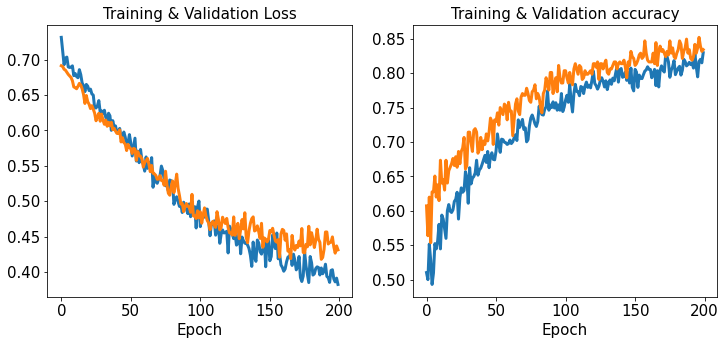

In [234]:
import matplotlib.pyplot as plt

hist=history.history

fig=plt.figure(figsize=(12,5))
ax=fig.add_subplot(1,2,1)
ax.plot(hist['loss'],lw=3)
ax.plot(hist['val_loss'],lw=3)
ax.set_title('Training & Validation Loss',size=15)
ax.set_xlabel('Epoch',size=15)
ax.tick_params(axis='both',which='major',labelsize=15)
ax=fig.add_subplot(1,2,2)
ax.plot(hist['accuracy'],lw=3)
ax.plot(hist['val_accuracy'],lw=3)
ax.set_title('Training & Validation accuracy',size=15)
ax.set_xlabel('Epoch',size=15)
ax.tick_params(axis='both',which='major',labelsize=15)
plt.show()




In [32]:
!pip install shap

     |████████████████████████████████| 276kB 2.8MB/s 
  Created wheel for shap: filename=shap-0.35.0-cp36-cp36m-linux_x86_64.whl size=394130 sha256=fa7a3695c4152743202e7de8bd95b7d76cec14ad3ea03f3ef255b7369251cec7
  Stored in directory: /root/.cache/pip/wheels/e7/f7/0f/b57055080cf8894906b3bd3616d2fc2bfd0b12d5161bcb24ac
Successfully built shap


In [235]:
import shap

explainer = shap.DeepExplainer(model, np.array(X_train_new))

In [236]:
shap_values  = explainer.shap_values(np.array(X_test_new))

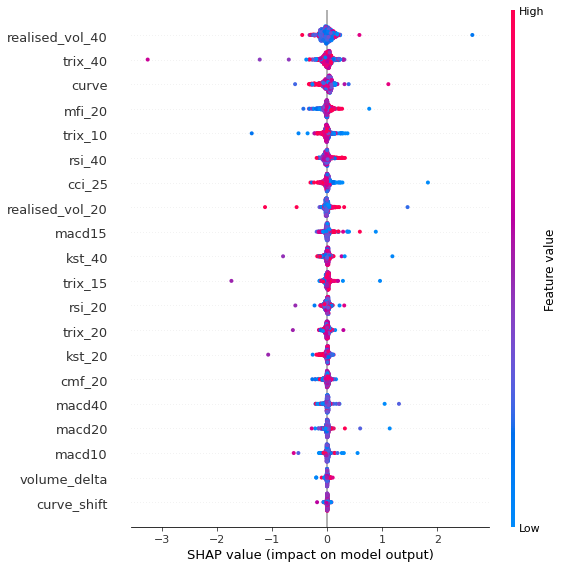

In [237]:
shap.summary_plot(shap_values[1], X_test_new)

In [238]:
pred=model.predict(X_test_new)
pred.argmax(axis=1)

array([0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1,

In [239]:
from sklearn.metrics import classification_report, confusion_matrix

cm=confusion_matrix(test_labels, pred.argmax(axis=1))

Confusion Matrix


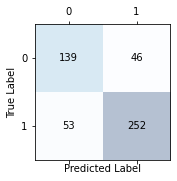

In [240]:
print('Confusion Matrix')
fig,ax = plt.subplots(figsize=(2.5,2.5))
ax.matshow(cm,cmap=plt.cm.Blues,alpha=0.3)
for i in range(cm.shape[0]):
  for j in range(cm.shape[1]):
    ax.text(x=j,y=i,
            s=cm[i,j],
            va='center',ha='center')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()



In [241]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score, f1_score

print('Precision: %.3f' % precision_score(y_true=test_labels,y_pred=pred.argmax(axis=1)))

print('Recall: %.3f' % recall_score(y_true=test_labels,y_pred=pred.argmax(axis=1)))

print('F1: %.3f' % f1_score(y_true=test_labels,y_pred=pred.argmax(axis=1)))

Precision: 0.846
Recall: 0.826
F1: 0.836


In [242]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2
import xgboost as xgb
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer

In [243]:
pipe = Pipeline([
  ('fs', SelectKBest()),
  ('clf', xgb.XGBClassifier(objective='binary:logistic'))
])

In [247]:
search_space = [
  {
    'clf__n_estimators': [200],
    'clf__learning_rate': [0.05, 0.1],
    'clf__max_depth': range(3, 10),
    'clf__colsample_bytree': [i/10.0 for i in range(1, 3)],
    'clf__gamma': [i/10.0 for i in range(3)],
    'fs__score_func': [mutual_info_classif,f_classif],
    'fs__k': [30,40],
  }
]

In [248]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

In [249]:
scoring = {'AUC':'roc_auc', 'Accuracy':make_scorer(accuracy_score)}

In [250]:
grid = GridSearchCV(
  pipe,
  param_grid=search_space,
  cv=kfold,
  scoring=scoring,
  refit='AUC',
  verbose=1,
  n_jobs=-1
)

In [251]:
model = grid.fit(normed_train_data, train_labels)

Fitting 5 folds for each of 336 candidates, totalling 1680 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   25.5s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed: 12.6min
[Parallel(n_jobs=-1)]: Done 1680 out of 1680 | elapsed: 17.4min finished


In [252]:
import pickle

# Dictionary of best parameters
best_pars = grid.best_params_
# Best XGB model that was found based on the metric score you specify
best_model = grid.best_estimator_
# Save model
pickle.dump(grid.best_estimator_, open('gdrive/My Drive/SS_AITrader/'+stock+'/xgb_'+stock+'_log_reg.pickle', "wb"))

In [253]:
predict = model.predict(normed_test_data)
print('Best AUC Score: {}'.format(model.best_score_))
print('Accuracy: {}'.format(accuracy_score(test_labels, predict)))
cm=confusion_matrix(test_labels,predict)

Best AUC Score: 0.937789992935446
Accuracy: 0.8673469387755102


Confusion Matrix


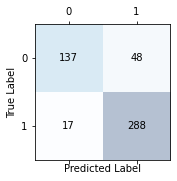

In [254]:
print('Confusion Matrix')
fig,ax = plt.subplots(figsize=(2.5,2.5))
ax.matshow(cm,cmap=plt.cm.Blues,alpha=0.3)
for i in range(cm.shape[0]):
  for j in range(cm.shape[1]):
    ax.text(x=j,y=i,
            s=cm[i,j],
            va='center',ha='center')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [255]:
print(model.best_params_)

{'clf__colsample_bytree': 0.2, 'clf__gamma': 0.2, 'clf__learning_rate': 0.05, 'clf__max_depth': 8, 'clf__n_estimators': 200, 'fs__k': 40, 'fs__score_func': <function mutual_info_classif at 0x7f9d435a61e0>}


In [201]:
k=40
select_k_best = SelectKBest(mutual_info_classif, k=k)
select_k_best.fit(normed_train_data, train_labels)
selected_features_mic = itemgetter(*select_k_best.get_support(indices=True))(list_features)

list_features = list(normed_train_data.columns)
feat_idx = []
for c in selected_features_mic:
      feat_idx.append(list_features.index(c))

feat_idx = sorted(feat_idx)
X_train_new=normed_train_data.iloc[:, feat_idx]
X_test_new=normed_test_data.iloc[:, feat_idx]




In [257]:
model_opt = xgb.XGBClassifier(max_depth=8,
                        objective='binary:logistic',
                        n_estimators=200,
                        learning_rate = 0.05,
                        colsample_bytree= 0.2,
                        gamma= 0.2)
eval_set = [(X_train_new, train_labels), (X_test_new, test_labels)]
model_opt.fit(X_train_new, train_labels, early_stopping_rounds=15, eval_metric=["error", "logloss"], eval_set=eval_set, verbose=True)

[0]	validation_0-error:0.194898	validation_0-logloss:0.672394	validation_1-error:0.265306	validation_1-logloss:0.677651
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 15 rounds.
[1]	validation_0-error:0.194388	validation_0-logloss:0.663046	validation_1-error:0.271429	validation_1-logloss:0.671122
[2]	validation_0-error:0.187755	validation_0-logloss:0.651994	validation_1-error:0.273469	validation_1-logloss:0.665271
[3]	validation_0-error:0.188776	validation_0-logloss:0.642406	validation_1-error:0.279592	validation_1-logloss:0.660506
[4]	validation_0-error:0.173469	validation_0-logloss:0.628444	validation_1-error:0.269388	validation_1-logloss:0.65115
[5]	validation_0-error:0.180102	validation_0-logloss:0.616825	validation_1-error:0.27551	validation_1-logloss:0.644122
[6]	validation_0-error:0.163776	validation_0-logloss:0.605281	validation_1-error:0.259184	validation_1-logloss:0.6368

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.2, gamma=0.2,
              learning_rate=0.05, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [258]:

# make predictions for test data
y_pred = model_opt.predict(X_test_new)
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(test_labels, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 86.53%


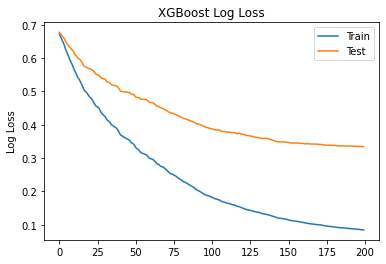

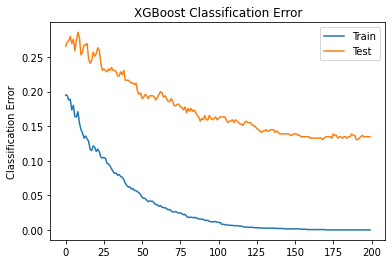

In [259]:
from matplotlib import pyplot

results = model_opt.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
pyplot.ylabel('Log Loss')
pyplot.title('XGBoost Log Loss')
pyplot.show()
# plot classification error
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
pyplot.ylabel('Classification Error')
pyplot.title('XGBoost Classification Error')
pyplot.show()

In [260]:
shap_values = shap.TreeExplainer(model_opt).shap_values(X_test_new) 

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


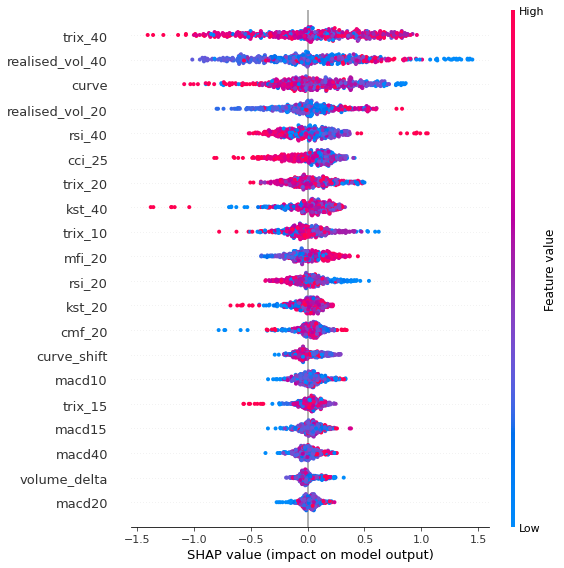

In [261]:
shap.summary_plot(shap_values, X_test_new)

In [262]:
predict = model_opt.predict(X_test_new)

cm=confusion_matrix(test_labels,predict)

Confusion Matrix


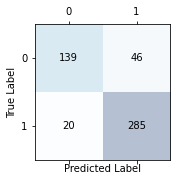

In [263]:
print('Confusion Matrix')
fig,ax = plt.subplots(figsize=(2.5,2.5))
ax.matshow(cm,cmap=plt.cm.Blues,alpha=0.3)
for i in range(cm.shape[0]):
  for j in range(cm.shape[1]):
    ax.text(x=j,y=i,
            s=cm[i,j],
            va='center',ha='center')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()